# City Supply and Demand Data

## Outline

- [Objective](#objective)
- [Setup](#setup)
- [Data Exploration](#data-exploration)
- [Data Processing](#data-processing)
- [Date of Most Completed Trips](#date-most-trips)
- [Highest Number of Completed Trips within 24 hours](#highest-trips-24)
- [Hour of Most Requests](#hour-most-requests)
- [Percentage of Zeroes on Weekends](#percentage-zeroes-weekends)
- [Weighted Average Ratio of Completed Trips per Driver](#ratio-trips-driver)
- [Busiest 8 Hour Shifts](#busiest-shifts)
- [Driver Supply and Demand](#driver-supply-demand)
- [Highest Zeroes to Eyeballs](#highest-zeroes-eyeballs)
- [Highest Eyeball to Driver](#highest-eyeball-driver)
- [Analysis Time Frame](#analysis-time-frame)
- [Best End Day](#best-end-day)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read dataset
df = pd.read_csv('data/raw/dataset_1.csv')

## Data Exploration <a id='data-exploration'></a>

In [3]:
# Show first 5 rows of DataFrame
df.head()

,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
0,10-Sep-12,7,5,0,2,2,9
1,NaN,8,6,0,2,2,14
2,NaN,9,8,3,0,0,14
3,NaN,10,9,2,0,1,14
4,NaN,11,11,1,4,4,11


In [4]:
# Get shape of data
print(f'Rows: {df.shape[0]}')
print(f'Columns: {df.shape[1]}')

Rows: 336
Columns: 7


In [5]:
# Get column names
df.columns

Index(['Date', 'Time (Local)', 'Eyeballs ', 'Zeroes ', 'Completed Trips ',
       'Requests ', 'Unique Drivers'],
      dtype='object')

In [6]:
# Get data types
df.dtypes

Date                object
Time (Local)         int64
Eyeballs             int64
Zeroes               int64
Completed Trips      int64
Requests             int64
Unique Drivers       int64
dtype: object

## Data Processing <a id='data-processing'><a>

In [7]:
# Forward fill missing dates
df = df.ffill()

In [8]:
# Show processed DataFramedf.head(n=10)

In [9]:
# Strip extra spaces
df.columns = df.columns.str.strip()

# Convert to lowercase
df.columns = df.columns.str.lower()

# Replace spaces with underscores
df.columns = df.columns.str.replace(pat=' ', repl='_')

# Remove special characters
df.columns = df.columns.str.replace(pat='[^a-zA-Z0-9_]', repl='', regex=True)

In [10]:
# Show cleaned column names
df.columns

Index(['date', 'time_local', 'eyeballs', 'zeroes', 'completed_trips',
       'requests', 'unique_drivers'],
      dtype='object')

In [11]:
# Create timestamp column
df['timestamp'] = df['date'] + ' ' + df['time_local'].astype(str) + ':00'

In [12]:
# Convert timestamp column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%b-%y %H:%M')

In [13]:
# Show first 5 rows
df.head()

,date,time_local,eyeballs,zeroes,completed_trips,requests,unique_drivers,timestamp
0,10-Sep-12,7,5,0,2,2,9,2012-09-10 07:00:00
1,10-Sep-12,8,6,0,2,2,14,2012-09-10 08:00:00
2,10-Sep-12,9,8,3,0,0,14,2012-09-10 09:00:00
3,10-Sep-12,10,9,2,0,1,14,2012-09-10 10:00:00
4,10-Sep-12,11,11,1,4,4,11,2012-09-10 11:00:00


## Date of Most Completed Trips <a id='date-most-trips'></a>

Which date had the most completed trips during the two week period?

In [14]:
# Grouping by date, aggregate sum of numerical columns, find row with maximum completed trips
date_most_trips = df.groupby(by='date', as_index=False)['completed_trips'].sum().query(expr='completed_trips == (completed_trips.max())')['date'].values[0]
date_most_trips

'22-Sep-12'

In [15]:
# Printing results
print(f'Date of most completed trips: {date_most_trips}')

Date of most completed trips: 22-Sep-12


## Highest Number of Completed Trips within 24 hours <a id='highest-trips-24'></a>

What was the highest number of completed trips within a 24 hour period?

In [16]:
# Create new DataFrame and drop `date` column
df_q2 = df.drop(columns='date')

In [17]:
# Set `timestamp` column as index
df_q2 = df_q2.set_index(keys='timestamp')

In [18]:
# Calculate rolling sum with forward looking window with 24 observations (hours)
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=24)
df_q2 = df_q2.rolling(window=indexer, min_periods=1).sum()

In [19]:
# Get row with highest number of completed trips
df_q2.nlargest(n=1, columns='completed_trips')

,time_local,eyeballs,zeroes,completed_trips,requests,unique_drivers
timestamp,,,,,,
2012-09-21 17:00:00,276.0,1015.0,207.0,278.0,367.0,349.0


In [20]:
# Set time format
time_format = '%Y/%m/%d %H:%M'

# Create time interval column
df_q2['time_interval'] = df_q2.index.strftime(time_format) + ' - ' + (df_q2.index + pd.Timedelta('24 hours')).strftime(time_format)

In [21]:
# Show first 5 rows
df_q2.head()

,time_local,eyeballs,zeroes,completed_trips,requests,unique_drivers,time_interval
timestamp,,,,,,,
2012-09-10 07:00:00,276.0,212.0,38.0,29.0,39.0,150.0,2012/09/10 07:00 - 2012/09/11 07:00
2012-09-10 08:00:00,276.0,217.0,38.0,29.0,39.0,146.0,2012/09/10 08:00 - 2012/09/11 08:00
2012-09-10 09:00:00,276.0,222.0,40.0,27.0,37.0,138.0,2012/09/10 09:00 - 2012/09/11 09:00
2012-09-10 10:00:00,276.0,229.0,39.0,27.0,37.0,130.0,2012/09/10 10:00 - 2012/09/11 10:00
2012-09-10 11:00:00,276.0,232.0,38.0,28.0,37.0,124.0,2012/09/10 11:00 - 2012/09/11 11:00


In [22]:
# Get maximum completed trips
completed_trips = df_q2['completed_trips'].max()

# Get time interval of maximum completed trips
time_interval = df_q2.nlargest(n=1, columns='completed_trips')['time_interval'].values[0]

In [23]:
# Print results
print(f'Number of completed trips: {completed_trips}')
print(f'Time interval: {time_interval}')

Number of completed trips: 278.0
Time interval: 2012/09/21 17:00 - 2012/09/22 17:00


## Hour of Most Requests <a id='hour-most-requests'></a>

Which hour of the day had the most requests during the two week period?

In [24]:
# Get hour of maximum requests
hour_most_requests = df.groupby(by='time_local', as_index=False)['requests'].sum().query(expr='requests == requests.max()')['time_local'].values[0]
hour_most_requests

23

In [25]:
# Print results
print(f'Hour of most requests: {hour_most_requests}')

Hour of most requests: 23


## Percentage of Zeroes on Weekends <a id='percentage-zeroes-weekends'></a>

What percentage of all zeroes during the two week period occurred on the weekend (Friday at 5 pm to Sunday at 3 am)?

In [26]:
# Total zeroes in data
total_zeroes = df['zeroes'].sum()
total_zeroes

1429

In [27]:
# Weekend zeroes in data, given conditions

# Create `day` column
df['day'] = pd.to_datetime(arg=df['date'], format='%d-%b-%y').dt.dayofweek

# Calculate weekend zeroes
weekend_zeroes = df[((df['day'] == 4) & (df['time_local'] >= 17)) | (df['day'] == 5) | ((df['day'] == 6) & (df['time_local'] < 3))]['zeroes'].sum()
weekend_zeroes

641

In [28]:
# Calculate percentage of zeroes on weekends
print(f'Percentage of all zeroes on the weekends: {(weekend_zeroes / total_zeroes * 100):.2f}%')

Percentage of all zeroes on the weekends: 44.86%


- Zeroes are instances when a person opened the Uber application, and did not see any car.

## Weighted Average Ratio of Completed Trips per Driver <a id='ratio-trips-driver'></a>

What is the weighted average ratio of completed trips per driver during the two week period?

In [29]:
# Calculate ratio
df['completed_trip_ratio_per_driver'] = df['completed_trips'] / df['unique_drivers']

In [30]:
# Sample of data
df.sample(n=10)

,date,time_local,eyeballs,zeroes,completed_trips,requests,unique_drivers,timestamp,day,completed_trip_ratio_per_driver
222,19-Sep-12,13,14,4,3,4,7,2012-09-19 13:00:00,2,0.428571
251,20-Sep-12,18,26,5,3,4,11,2012-09-20 18:00:00,3,0.272727
49,12-Sep-12,8,28,2,8,8,11,2012-09-12 08:00:00,2,0.727273
250,20-Sep-12,17,37,4,5,9,8,2012-09-20 17:00:00,3,0.625000
174,17-Sep-12,13,19,3,1,2,8,2012-09-17 13:00:00,0,0.125000
329,24-Sep-12,0,7,2,1,2,2,2012-09-24 00:00:00,0,0.500000
219,19-Sep-12,10,12,3,0,2,12,2012-09-19 10:00:00,2,0.000000
234,20-Sep-12,1,1,0,0,1,1,2012-09-20 01:00:00,3,0.000000
150,16-Sep-12,13,21,4,0,0,5,2012-09-16 13:00:00,6,0.000000
157,16-Sep-12,20,25,10,7,10,7,2012-09-16 20:00:00,6,1.000000


In [31]:
# Drop rows with zero or NaN values in `unique_drivers` column
df_q5 = df[df['unique_drivers'] > 0]

In [32]:
# Calculate average ratio
average_ratio = np.average(df_q5['completed_trip_ratio_per_driver'])

In [33]:
# Calculate weighted average ratio with weights as day's completed trips
weighted_average_ratio = np.average(df_q5['completed_trip_ratio_per_driver'], weights=df_q5['completed_trips'])

In [34]:
print(f'Average ratio of completed trips per driver: {average_ratio}')
print(f'Weighted average ratio of completed trips per driver: {weighted_average_ratio}')

Average ratio of completed trips per driver: 0.4743397876937869
Weighted average ratio of completed trips per driver: 0.8282775715092395


## Busiest 8 Hour Shifts <a id='busiest-shifts'></a>

In drafting a driver schedule in terms of 8 hours shifts, when are the busiest 8 consecutive hours over the two week period in terms of unique requests? 

- A new shift starts every 8 hours.
- Assume that a driver will work the same shift each day.

In [35]:
# Set `timestamp` as index
df_q6 = df.set_index(keys='timestamp')

In [36]:
# Resample with 8 hours period
df_q6 = df_q6.resample(rule='8H').sum()

C:\Users\Abhigyan\AppData\Local\Temp\ipykernel_2532\2326913025.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_q6 = df_q6.resample(rule='8H').sum()


In [37]:
# Set time format
time_format = '%Y/%m/%d %H:%M'

# Create `time_interval` column
df_q6['time_interval'] = df_q6.index.strftime(time_format) + ' - ' + (df_q6.index + pd.Timedelta('8 hours')).strftime(time_format)

In [38]:
# Get busiest 8 hour time interval
busiest_shift = df_q6.nlargest(n=1, columns='requests')['time_interval'].values[0]

In [39]:
# Print results
print(f'Busiest 8 hour shift: {busiest_shift}')

Busiest 8 hour shift: 2012/09/21 16:00 - 2012/09/22 00:00


## Driver Supply and Demand <a id='driver-supply-demand'></a>

Does driver supply always increase when demand increases during the two week period?

In [40]:
# Create empty dataframe with only timestamps
difference_df = pd.DataFrame(df['timestamp'])

In [41]:
# Calculate request differences to find request increases
difference_df['request_diff'] = df['requests'].shift(-1) - df['requests']

# Calculate supply differences to find supply increases
difference_df['supply_diff'] = df['unique_drivers'].shift(-1) - df['unique_drivers']

In [42]:
# Sample of difference_df
difference_df.sample(n=10)

,timestamp,request_diff,supply_diff
213,2012-09-19 04:00:00,0.0,1.0
130,2012-09-15 17:00:00,17.0,0.0
160,2012-09-16 23:00:00,-1.0,-2.0
279,2012-09-21 22:00:00,17.0,0.0
222,2012-09-19 13:00:00,-3.0,1.0
228,2012-09-19 19:00:00,0.0,-1.0
330,2012-09-24 01:00:00,2.0,0.0
114,2012-09-15 01:00:00,13.0,-6.0
121,2012-09-15 08:00:00,0.0,0.0
26,2012-09-11 09:00:00,1.0,2.0


In [43]:
# Check if request increases, supply also increases
supply_demand_increase = (difference_df[difference_df['request_diff'] > 0]['supply_diff'] > 0).all().item()

In [44]:
# Print result
print(f'Driver supply always increases when demand increases: {supply_demand_increase}')

Driver supply always increases when demand increases: False


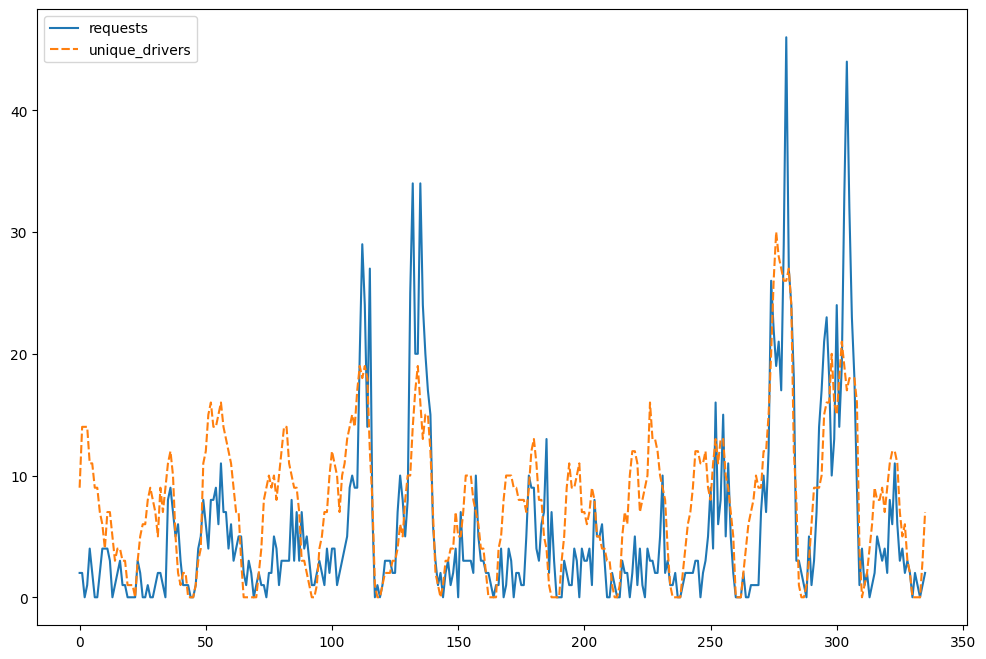

In [45]:
# Plot requests and unique drivers
plt.figure(figsize=(12, 8))
sns.lineplot(data=df[['requests', 'unique_drivers', 'timestamp']])
plt.show()

## Highest Zeroes to Eyeballs <a id='highest-zeroes-eyeballs'></a>

In which 72 hour period is the ratio of Zeroes to Eyeballs the highest?

- `Eyeballs` are when a person opened the Uber application.
- `Zeroes` are when a person opened the Uber application, and did not see any car.

In [46]:
# Drop `date` column
df_q8 = df.drop(columns='date')

In [47]:
# Set `timestamp` as index
df_q8 = df_q8.set_index('timestamp')

In [48]:
# Calculate rolling sum by 3 days (72 hours)
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=72)
df_q8 = df_q8.rolling(window=indexer, min_periods=1).sum().reset_index()

In [49]:
# Calculate zeros to eyeballs ratio
df_q8['zeroes_to_eyeballs_ratio'] = df_q8['zeroes'] / df_q8['eyeballs']

In [50]:
# Keep only rows from last 72 hours
df_q8 = df_q8[df_q8['timestamp'] <= (df_q8['timestamp'].max() - pd.DateOffset(days=3))]

In [51]:
# Set time format
time_format = "%Y/%m/%d %H:%M"

# Create `time_interval` column
df_q8['time_interval'] = df_q8['timestamp'].dt.strftime(time_format) +  " - " + (df_q8['timestamp'] + pd.Timedelta('3 days')).dt.strftime(time_format)

In [52]:
# Get highest zeroes to eyeballs ratio
max_zeroes_eyeballs = df_q8.nlargest(n=1, columns='zeroes_to_eyeballs_ratio')['zeroes_to_eyeballs_ratio'].values[0]

# Get time interval for highest zeroes to eyeballs ratio
max_zeroes_eyeballs_time_interval = df_q8.nlargest(n=1, columns='zeroes_to_eyeballs_ratio')['time_interval'].values[0]

In [53]:
# Print result
print(f'Highest zeroes to eyeballs ratio in 72 hours: {max_zeroes_eyeballs}')
print(f'72 hour period of highest zeroes to eyeballs ratio: {max_zeroes_eyeballs_time_interval}')

Highest zeroes to eyeballs ratio in 72 hours: 0.2929765886287625
72 hour period of highest zeroes to eyeballs ratio: 2012/09/15 05:00 - 2012/09/18 05:00


## Highest Eyeball to Driver <a id='highest-eyeball-driver'></a>

If you could add 5 drivers to any single hour of every day during the two week period, which hour should you add them to?

In [54]:
# Group by `time_local`, aggregate `eyeballs` and `unique_drivers` sum
df_q9 = df.groupby(by='time_local', as_index=False).agg(func={'eyeballs': 'sum', 'unique_drivers': 'sum'})

In [55]:
# Create eyeball to driver ratio
df_q9['eyeball_to_driver_ratio'] = df_q9['eyeballs'] / df_q9['unique_drivers']

In [56]:
# Get hour of highest eyeball to driver ratio
hour_add_driver = df_q9.nlargest(n=1, columns='eyeball_to_driver_ratio')['time_local'].values[0]

In [57]:
# Print results
print(f'Recommended hour to add drivers: {hour_add_driver}')

Recommended hour to add drivers: 23


## Analysis Time Frame <a id='analysis-time-frame'></a>

Are there exactly two weeks of data in this analysis?

In [58]:
# Calculate time difference between start and end, then compare to timedelta 14 days
two_weeks = df['timestamp'][df.shape[0] - 1] - df['timestamp'][0] == pd.Timedelta('14 days')

In [59]:
# Print results
print(f'Exactly two weeks of data: {two_weeks}')

Exactly two weeks of data: False


## Best End Day <a id='best-end-day'></a>

Looking at all of the data, which time might make the most sense to consider a true "end day" instead of midnight?

- When are both supply and demand at their natural minimums?

In [60]:
# Find minimum supply and demand per day
df_q11 = df.groupby(by='date', as_index=False).agg(min_supply_per_day=('unique_drivers', 'min'), min_demand_per_day=('requests', 'min'))

In [61]:
# Merge aggregated columns with original dataset on date
df_q11 = pd.merge(left=df, right=df_q11, on='date')

In [62]:
# Find hour when supply and demand are at natural minimums
min_hour = df_q11[(df_q11['min_supply_per_day'] == df_q11['unique_drivers']) & (df_q11['min_demand_per_day'] == df_q11['requests'])]['time_local'].mode()

In [63]:
# Print result
print(f'Hour of minimum supply and demand: {min_hour[0]}')

Hour of minimum supply and demand: 4


In [64]:
# Select numeric columns
df_agg_time = df.select_dtypes(include='number')

# Aggregate by `time_local` and sum columns
df_agg_time = df_agg_time.groupby(by='time_local', as_index=False).sum()

# Extract hour of minimum supply and demand
min_hour_value = df_agg_time['requests'][min_hour[0]]

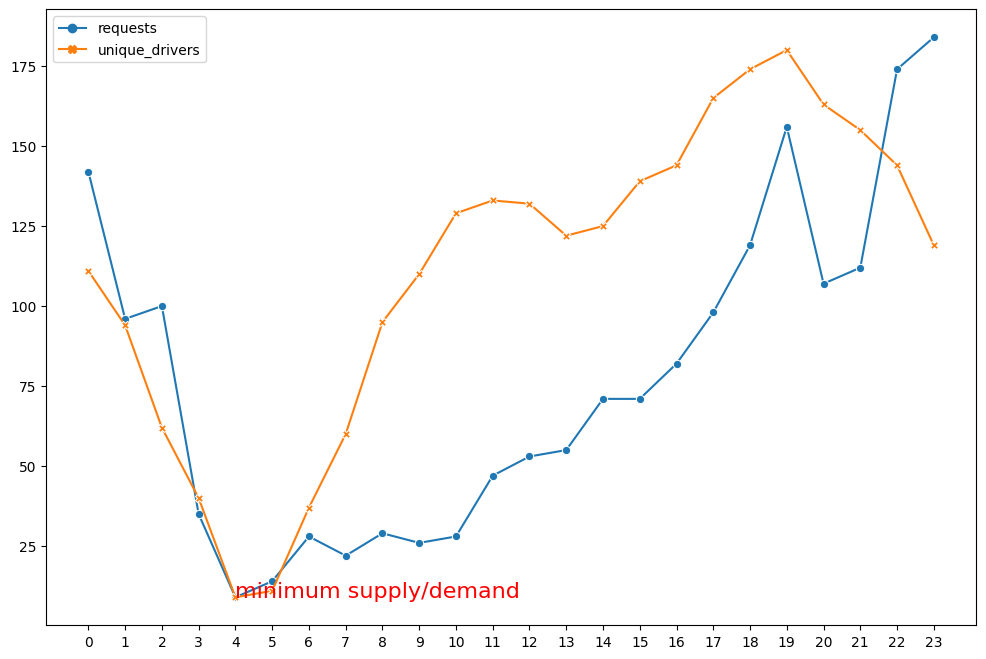

In [65]:
# Plot and annotate minimum hour

# Set figure size
plt.figure(figsize=(12, 8))

# Create line plot
fig = sns.lineplot(data=df_agg_time[['requests', 'unique_drivers']], markers=True, dashes=False)

# Set x-axis ticks to values in `time_local` column
fig.set_xticks(df_agg_time['time_local'])

# Add annotation to plot
plt.annotate('minimum supply/demand', xy=(min_hour[0], min_hour_value), color='r', fontsize=16)

# Display plot
plt.show()

- Supply and demand are at their natural minimums at 4 in the morning.
- A better end of day may be 4 am instead of 12 am midnight.